## SCANPY: HoC Automated Preprocessing

***Overview***

***Inputs: ***

***Outputs: ***

***Caveats: ***

***Contents ***

In [1]:
# Imports
import numpy as np
import pandas as pd
import scanpy.api as sc
import timeit
import glob
import copy
import os

### 0. Set Path Prefix

In [2]:
# Set path prefix
path_prefix = '/soe/apblair/sc_analysis/HoC_data/human/matrices_tsv/*.csv'

### 1. Ensembl to Hugo Mapping Dictionary

In [3]:
# Create ensembl to Hugo conversion dictionary
symbol2ensemble = pd.read_csv('/projects/sysbio/users/hzgong/pablo/cluster/brain_of_cells/v4/resources/gene_id_conversion.tsv', sep='\t', index_col=1)['ensembl']
symbol2ensemble = symbol2ensemble[symbol2ensemble.notnull()]
ensembl2symbol = dict(zip(symbol2ensemble.values,symbol2ensemble.index.values))

### 2. Single Cell Data Wrangling

In [4]:
# Check how many different cell ages are present
cell_batch = set()
for batches in glob.glob(path_prefix):
    cell_batch.add(batches.split('/')[-1][2:5])

In [5]:
cell_dict = {key: [] for key in list(cell_batch)}
for sc_data in glob.glob(path_prefix):
    
    # Create directory path and denote by cell type and age
    directory = '/projects/sysbio/users/apblair/sc_analysis/' + sc_data.split('/')[-1].split('.')[0]
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

    for age in cell_dict.keys():
            if age == sc_data.split('/')[-1][2:5]:
                # Create anndata structure for cell batch data
                adata = sc.read(sc_data, cache=True, first_column_names=True).T
                # Add cell type to the cell batch's barcode
                adata.obs = adata.obs.rename(index={key: sc_data.split('/')[-1].split('.')[0].split('_')[-1] + "_" + key for key in adata.obs.index.tolist()})
                # Add metadata batch information to anndata object
                adata.obs['batch_name'] = sc_data.split('/')[-1].split('.')[0]
                # Convert gene ID's from Ensembl to Hugo
                adata.var = adata.var.rename(index=ensembl2symbol)
                # Append cell data to dictionary
                cell_dict[age].append({sc_data.split('/')[-1].split('.')[0].split('_')[-1]: adata})
                

In [6]:
# # Concatenate each cell batch's data sets
concatenated_cell_dict = {key: None for key in list(cell_batch)}
for keys, values in cell_dict.items():
    concatenated_cell_dict[keys] = values[0][list(values[0].keys())[-1]].concatenate([list(items.values())[0] for items in values[1:]], join='outer')

Making variable names unique for controlled concatenation.
Making variable names unique for controlled concatenation.


In [7]:
# Check concatenation
check_concatenation = set()
for keys, values in concatenated_cell_dict.items():
    for items in values.obs.index.tolist():
        check_concatenation.add(items.split("_")[0])
    print(keys, values)
    print(check_concatenation)
    print("\n")

13W AnnData object with n_obs × n_vars = 23594 × 33694 
    obs: 'batch_name', 'batch'
{'RV', 'LV', 'LA', 'RA', 'IVS'}


11W AnnData object with n_obs × n_vars = 19411 × 33694 
    obs: 'batch_name', 'batch'
{'RV', 'LV', 'LA', 'RA', 'IVS'}




### 3. Batch Name to Integer Mapping Dictionary

In [8]:
# Create a batch name to integer mapping dictionary,
# in case a user is interested in running a batch
# correction with regress.out function
batch_mapping_dict = {}

inc = 0
for keys in concatenated_cell_dict.keys():
    for k in concatenated_cell_dict[keys].obs['batch'].unique():
        batch_mapping_dict[k] = inc
        inc += 1

for keys in concatenated_cell_dict.keys():
    concatenated_cell_dict[keys].obs["batch"].replace(batch_mapping_dict, inplace=True)
    
# Create a copy of the pre-filtered dictionary
filtered_cell_dict = copy.deepcopy(concatenated_cell_dict)

## 4. Preprocessing

### 4.1. Preliminary Filtering

***pp.filter_cells()***

* Filter cell outliers based on counts and numbers of genes expressed.
    - Default: min_cells = 3

***pp.filter_genes()***

* Filter genes based on number of cells or counts.
    - Default: min_genes = 200

In [10]:
# User parameters
minimum_cells = 3
minimum_genes = 200

In [11]:
# Preliminary filtering
for key in filtered_cell_dict.keys():
    sc.pp.filter_cells(filtered_cell_dict[key], min_genes=minimum_genes)
    sc.pp.filter_genes(filtered_cell_dict[key], min_cells=minimum_cells)

### 4.2. Mitochondria Statistics

In [12]:
for key in filtered_cell_dict.keys():
    mito_genes = [name for name in filtered_cell_dict[key].var_names if name.startswith('MT.') or name.startswith('MT-')]
    filtered_cell_dict[key].obs['percent_mito'] = np.sum(filtered_cell_dict[key][:, mito_genes].X, axis=1) / np.sum(filtered_cell_dict[key].X, axis=1)
    filtered_cell_dict[key].obs['n_counts'] = np.sum(filtered_cell_dict[key].X, axis=1)

... storing 'batch_name' as categorical


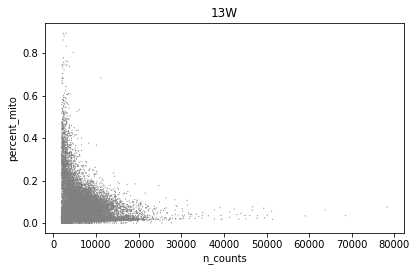

... storing 'batch_name' as categorical


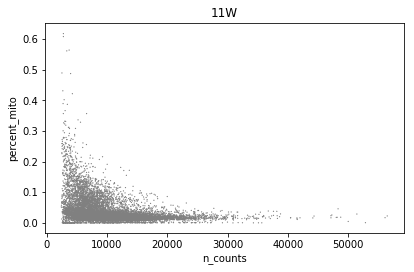

In [13]:
# Plot number of counts against percentage of mitochondria genes
for key in filtered_cell_dict.keys():
    sc.pl.scatter(filtered_cell_dict[key], x = 'n_counts', y = 'percent_mito', title=key)

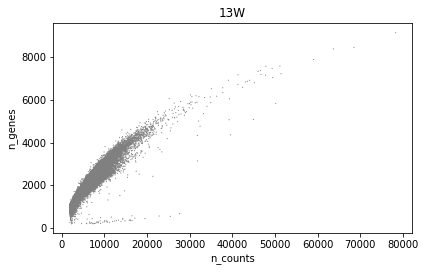

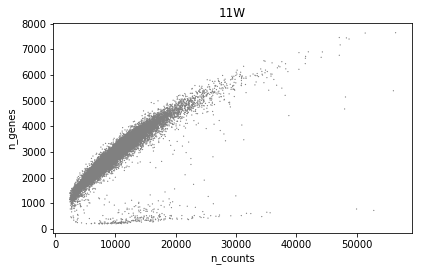

In [14]:
# Plot number of counts against number of genes
for key in filtered_cell_dict.keys():
    sc.pl.scatter(filtered_cell_dict[key], x='n_counts', y='n_genes', title=key)

### 4.3. Mitochondria Filtering

The user may set the parameters for gating cells: (default values)

* ***thrsh_mito***=0.2
* ***up_thrsh_genes***=5000
* ***low_thrsh_genes***=50

In [15]:
# User parameters
thrsh_mito = 0.2
up_thrsh_genes = 5000
low_thrsh_genes = 50

In [17]:
mito_filtered_cell_dict = copy.deepcopy(filtered_cell_dict)
for key in mito_filtered_cell_dict.keys():
    mito_filtered_cell_dict[key][mito_filtered_cell_dict[key].obs['n_genes']< up_thrsh_genes, :] 
    mito_filtered_cell_dict[key][mito_filtered_cell_dict[key].obs['n_genes']>low_thrsh_genes, :] 
    mito_filtered_cell_dict[key][mito_filtered_cell_dict[key].obs['n_genes']<thrsh_mito, :] 

### 4.4. Cell Normalization

***pp.normalize_per_cell()***

- Normalize total counts per cell.
    - Default: cell_counts = 1e4

In [18]:
# User parameters
cell_counts = 1e4

In [19]:
normalized_mito_filtered_cell_dict = copy.deepcopy(mito_filtered_cell_dict)
for key in normalized_mito_filtered_cell_dict.keys():
    sc.pp.normalize_per_cell(normalized_mito_filtered_cell_dict[key], counts_per_cell_after=cell_counts)

### 4.5. Variable Gene Filtering

***pp.filter_genes_dispersion()***

- Extract highly variable genes

13W


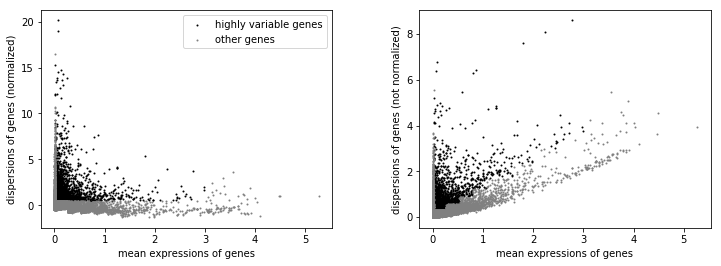

Number of variable genes identified:  1930
11W


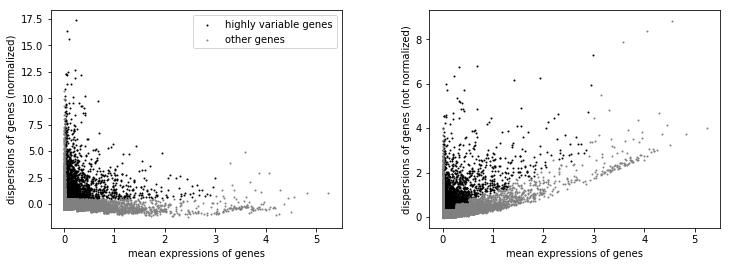

Number of variable genes identified:  2153


In [25]:
variable_gene_filtered_cell_dict = copy.deepcopy(mito_filtered_cell_dict)
for key in variable_gene_filtered_cell_dict.keys():
    filtered_cell = sc.pp.filter_genes_dispersion(variable_gene_filtered_cell_dict[key].X, min_mean=0.0125, max_mean=3, min_disp=0.5)
    print(key)
    sc.pl.filter_genes_dispersion(filtered_cell)
    variable_gene_filtered_cell_dict[key] = variable_gene_filtered_cell_dict[key][:, filtered_cell.gene_subset]
    print('Number of variable genes identified: ',sum(filtered_cell.gene_subset))

In [30]:
variable_gene_filtered_cell_dict['11W']

View of AnnData object with n_obs × n_vars = 19324 × 2153 
    obs: 'batch_name', 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

### 4.6. Scale Data

In [21]:
log_filtered_cell_dict = copy.deepcopy(variable_gene_filtered_cell_dict)
for key in log_filtered_cell_dict.keys():
    log_filtered_cell_dict[key] = sc.pp.log1p(log_filtered_cell_dict[key])

In [27]:
log_filtered_cell_dict['11W']

### 4.7 Regression

In [26]:
regressed_log_filtered_cell_dict = copy.deepcopy(log_filtered_cell_dict)
for key in regressed_log_filtered_cell_dict.keys():
    regressed_log_filtered_cell_dict[key] = sc.pp.regress_out(regressed_log_filtered_cell_dict[key], ['n_counts','percent_mito'])

AttributeError: 'NoneType' object has no attribute 'X'